# Solution for Portuguese banking institution by 2022/P/1123

### Install required packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats


#### Load data

In [28]:

df=pd.read_csv('banking.csv')

df.shape

(41188, 21)

#### Check the types of the data set

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp_var_rate    41188 non-null  float64
 16  cons_price_idx  41188 non-null  float64
 17  cons_conf_idx   41188 non-null 

#### Describing the data set


In [30]:
df.describe()


,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.112654
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528,0.316173
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


### check  for missing values

In [31]:

df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64

In [32]:
df.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1
5,30,management,divorced,basic.4y,no,yes,no,cellular,jul,tue,...,8,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,0
6,37,blue-collar,married,basic.4y,no,yes,no,cellular,may,thu,...,1,999,0,nonexistent,-1.8,92.893,-46.2,1.327,5099.1,0
7,39,blue-collar,divorced,basic.9y,no,yes,no,cellular,may,fri,...,1,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,0
8,36,admin.,married,university.degree,no,no,no,cellular,jun,mon,...,1,3,1,success,-2.9,92.963,-40.8,1.266,5076.2,1
9,27,blue-collar,single,basic.4y,no,yes,no,cellular,apr,thu,...,2,999,1,failure,-1.8,93.075,-47.1,1.410,5099.1,0


### Handling unkown values


In [33]:
unknown_counts = df.apply(lambda x: x[x == 'unknown'].count())
unknown_counts

age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp_var_rate         0
cons_price_idx       0
cons_conf_idx        0
euribor3m            0
nr_employed          0
y                    0
dtype: int64

As we see here there are some unkown values in columns job,marital,eduction,default,housing and loan .As the next step we gonna replace the unkown values with mode value of the each column

In [34]:
for column in ['job','marital','education','default','housing','loan']:
    mode_val = df[column].mode()[0]
    df[column] = df[column].replace('unknown',mode_val)
unknown_counts = df.apply(lambda x: x[x == 'unknown'].count())
unknown_counts

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp_var_rate    41188 non-null  float64
 16  cons_price_idx  41188 non-null  float64
 17  cons_conf_idx   41188 non-null 

### Removing Outliers

In [44]:

int_float_cols = df.select_dtypes(include=['int64', 'float64']).columns
for column in int_float_cols:
 
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)

  
    IQR = Q3 - Q1

 
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR


    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df.shape
  


(22149, 21)

data points with Z-scores between -3 and 3 are considered within the normal range . we can find outliers using interquartile ranges also

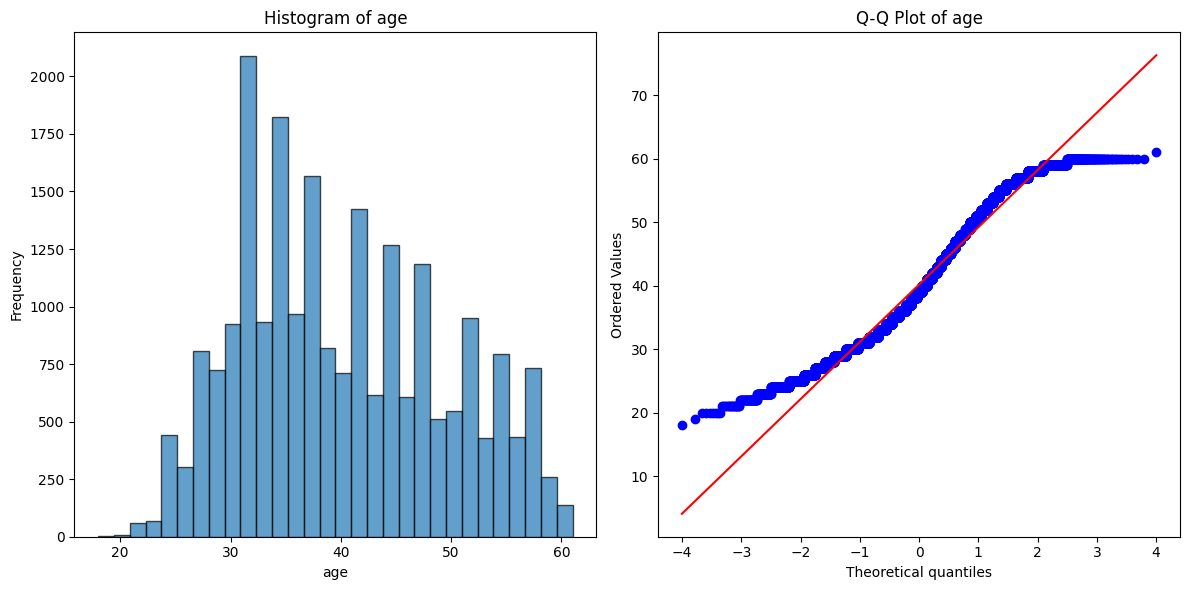

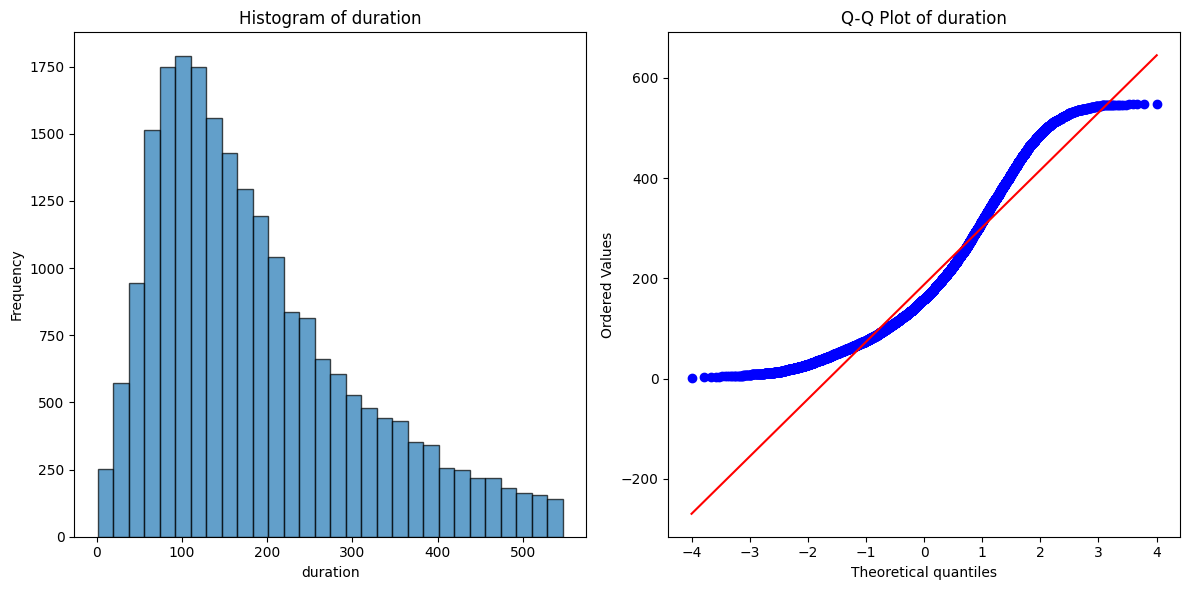

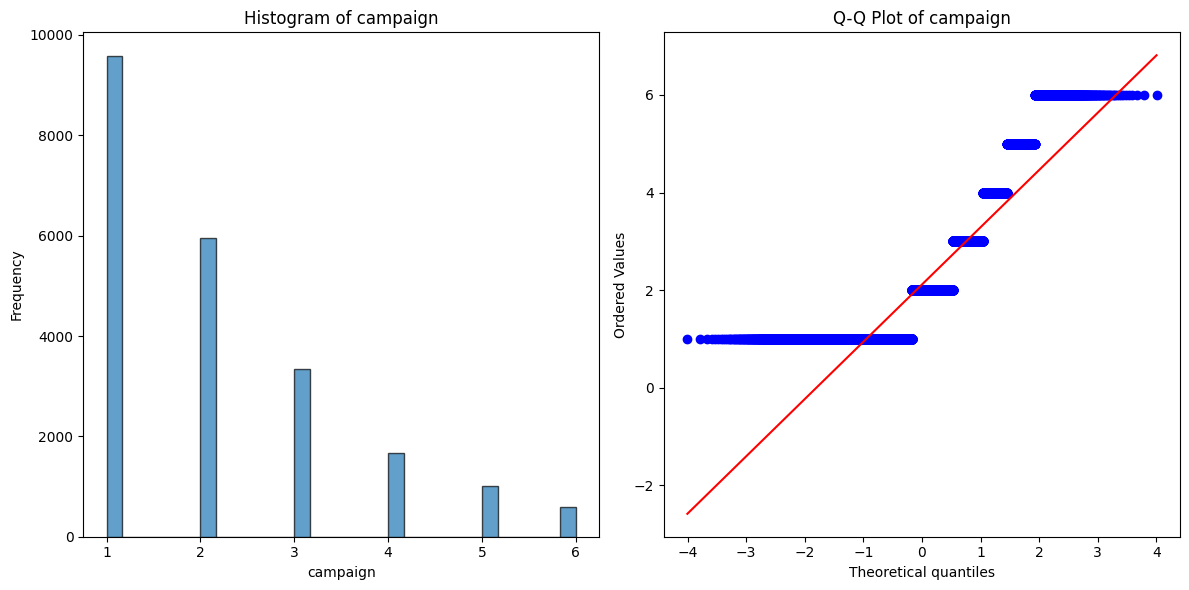

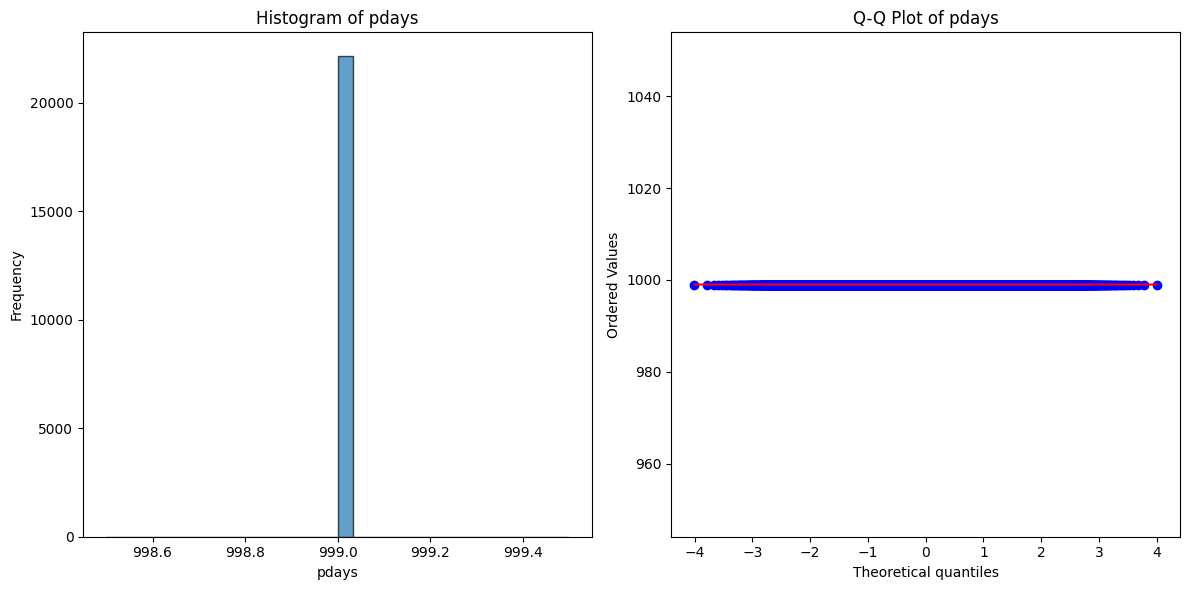

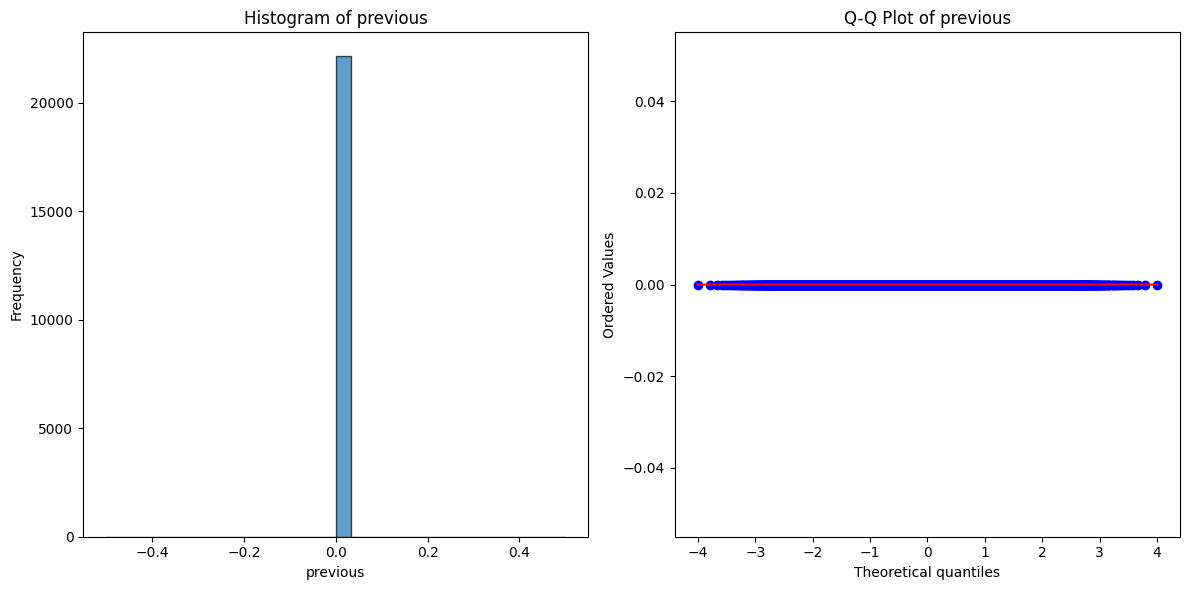

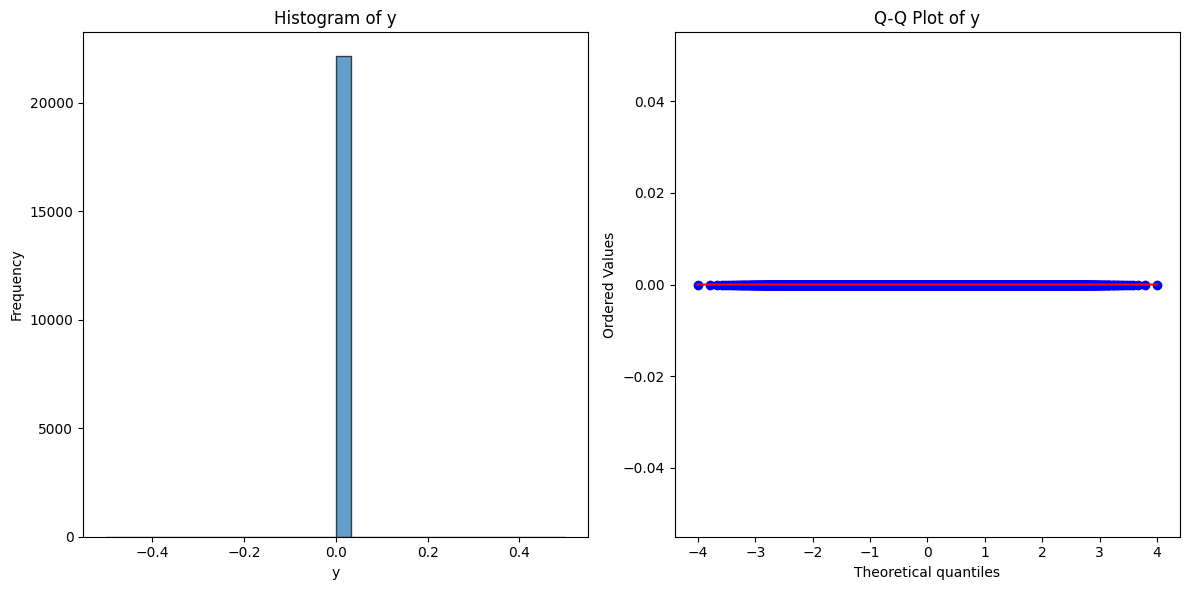

In [45]:
def plot_feature_analysis(df, feature):
    plt.figure(figsize=(12, 6))

    # Histogram
    plt.subplot(1, 2, 1)
    plt.hist(df[feature], bins=30, edgecolor='k', alpha=0.7)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

    # Q-Q Plot
    plt.subplot(1, 2, 2)
    stats.probplot(df[feature], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {feature}')

    plt.tight_layout()
    plt.show()

for column in df.select_dtypes(include=['int64']):
    plot_feature_analysis(df, column)




due to skeweness we need to get rid of them to make our distribution looks normal.I use log transformation for this.Log trnasformation mostly used in right skeweness

Handle age skeweness

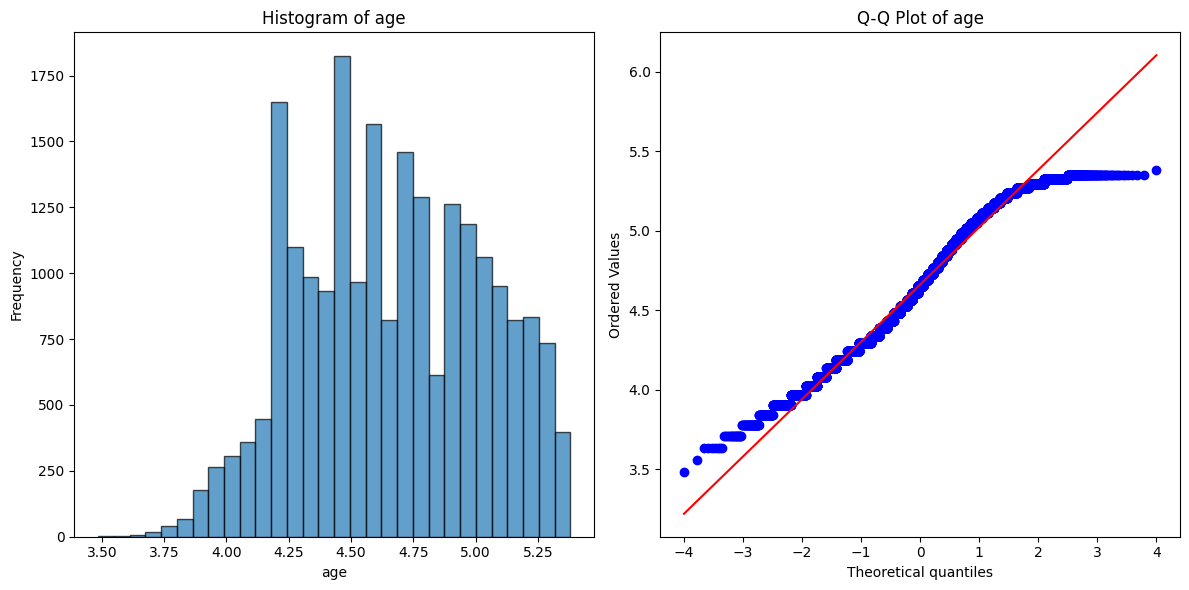

In [49]:

log_age,_ = stats.boxcox(df['age'])
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(log_age, bins=30, edgecolor='k', alpha=0.7)
plt.title(f'Histogram of age')
plt.xlabel('age')
plt.ylabel('Frequency')


plt.subplot(1, 2, 2)
stats.probplot(log_age, dist="norm", plot=plt)
plt.title(f'Q-Q Plot of age')

plt.tight_layout()
plt.show()




handle duration skeweness

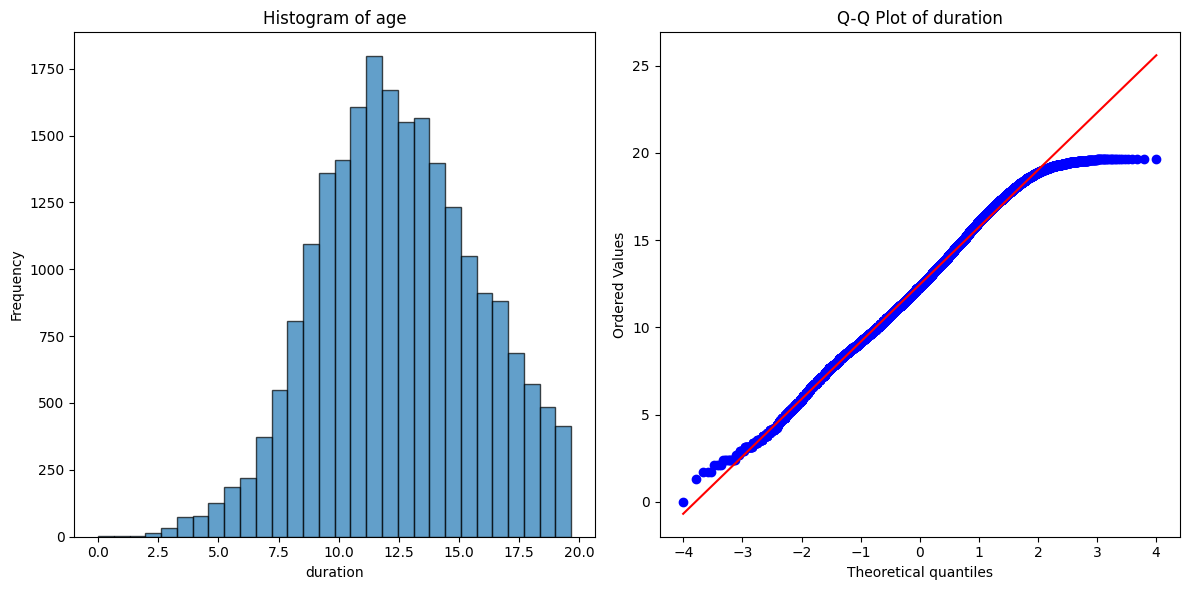

In [50]:

if (df['duration'] <= 0).any():
  
    df['duration'] += abs(df['duration'].min()) + 1


log_duration, _ = stats.boxcox(df['duration'])
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(log_duration, bins=30, edgecolor='k', alpha=0.7)
plt.title(f'Histogram of age')
plt.xlabel('duration')
plt.ylabel('Frequency')


plt.subplot(1, 2, 2)
stats.probplot(log_duration, dist="norm", plot=plt)
plt.title(f'Q-Q Plot of duration')

plt.tight_layout()
plt.show()

handle campaign skeweness

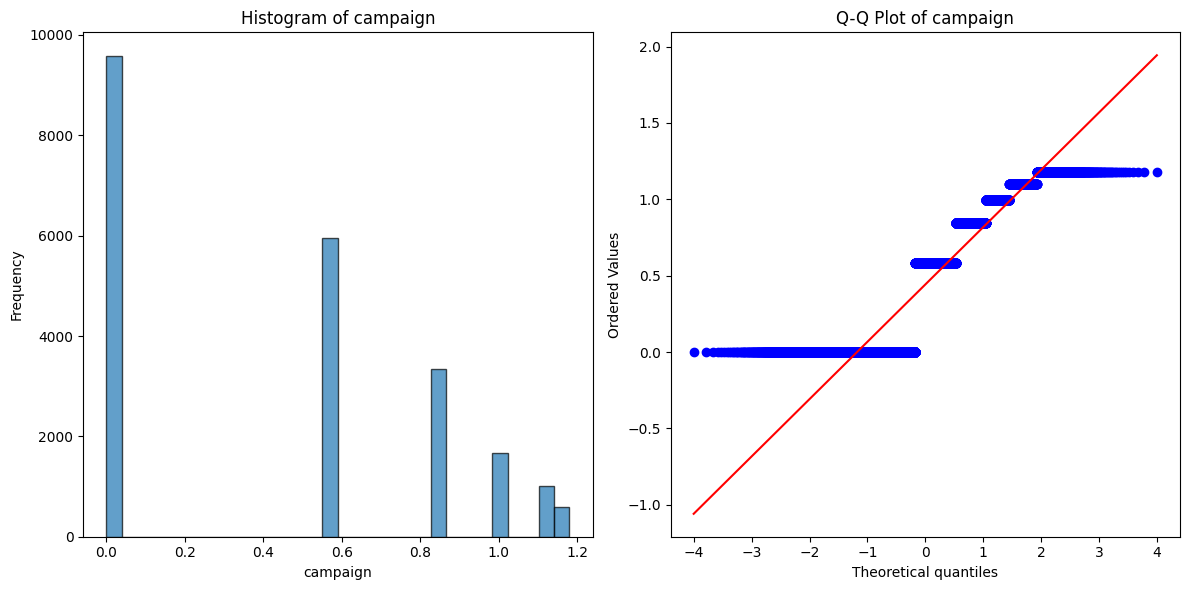

In [51]:

log_campaign, _ = stats.boxcox(df['campaign'])
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(log_campaign, bins=30, edgecolor='k', alpha=0.7)
plt.title(f'Histogram of campaign')
plt.xlabel('campaign')
plt.ylabel('Frequency')


plt.subplot(1, 2, 2)
stats.probplot(log_campaign, dist="norm", plot=plt)
plt.title(f'Q-Q Plot of campaign')

plt.tight_layout()
plt.show()

<Axes: ylabel='duration'>

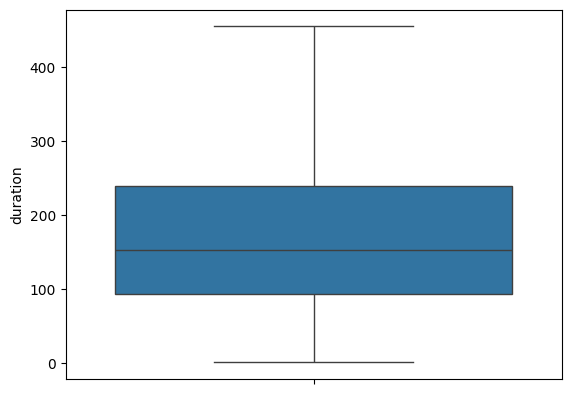

In [57]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['duration'].quantile(0.25)
Q3 = df['duration'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
df = df[(df['duration'] >= lower_bound) & (df['duration'] <= upper_bound)]
sns.boxplot(df['duration'])


### One hot encoding and label encoding


In [58]:
df['month'] = LabelEncoder().fit_transform(df['month'])
df['day_of_week'] = LabelEncoder().fit_transform(df['day_of_week'])
df_encoded = pd.get_dummies(df, columns=['job','marital','education','default','housing','loan','poutcome','y'], drop_first=True)
df_encoded.head(10)

,age,contact,month,day_of_week,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,...,marital_single,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,default_yes,housing_yes,loan_yes
0,44,cellular,0,2,211,1,999,0,1.4,93.444,...,False,False,False,False,False,False,False,False,True,False
1,53,cellular,5,0,139,1,999,0,-0.1,93.200,...,False,False,False,False,False,False,True,False,False,False
10,34,telephone,4,0,63,2,999,0,1.1,93.994,...,True,False,False,False,False,False,True,False,False,False
15,52,cellular,2,2,118,2,999,0,1.4,93.918,...,False,False,False,True,False,False,False,False,True,False
18,28,telephone,4,2,141,1,999,0,1.1,93.994,...,False,False,True,False,False,False,False,False,False,False
19,26,cellular,2,1,105,4,999,0,1.4,93.918,...,True,False,True,False,False,False,False,False,True,True
22,40,telephone,2,4,341,1,999,0,1.4,93.918,...,False,False,False,False,False,False,True,False,True,False
23,32,cellular,2,2,36,1,999,0,1.4,93.918,...,True,False,False,False,False,True,False,False,False,False
24,41,cellular,2,2,242,3,999,0,1.4,93.918,...,False,False,False,True,False,False,False,False,True,True
29,38,telephone,2,3,42,5,999,0,1.4,93.918,...,True,False,False,False,False,False,False,False,False,False


In [59]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21289 entries, 0 to 41187
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            21289 non-null  int64  
 1   contact                        21289 non-null  object 
 2   month                          21289 non-null  int64  
 3   day_of_week                    21289 non-null  int64  
 4   duration                       21289 non-null  int64  
 5   campaign                       21289 non-null  int64  
 6   pdays                          21289 non-null  int64  
 7   previous                       21289 non-null  int64  
 8   emp_var_rate                   21289 non-null  float64
 9   cons_price_idx                 21289 non-null  float64
 10  cons_conf_idx                  21289 non-null  float64
 11  euribor3m                      21289 non-null  float64
 12  nr_employed                    21289 non-null  floa

### checkin for outliers    